In [ ]:
import numpy as np
import pandas as pd
import os
import re 
import nltk 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
import pickle

nltk.download("stopwords")
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras import losses
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df1 = pd.read_csv('/content/Twitter_Data.csv')

df1.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df2 = pd.read_csv('/content/apple-twitter-sentiment-texts.csv')
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})

df2.head()

,clean_text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1.0
1,What Happened To Apple Inc? http://t.co/FJEX...,0.0
2,Thank u @apple I can now compile all of the pi...,1.0
3,The oddly uplifting story of the Apple co-foun...,0.0
4,@apple can i exchange my iphone for a differen...,0.0


In [ ]:
df3 = pd.read_csv('/content/finalSentimentdata2.csv')
df3 = df3.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df3['category'] = df3['category'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy':1.0})
df3 = df3.drop(['Unnamed: 0'], axis=1)

df3.head()

,category,clean_text
0,-1.0,agree the poor in india are treated badly thei...
1,1.0,if only i could have spent the with this cutie...
2,1.0,will nature conservation remain a priority in ...
3,-1.0,coronavirus disappearing in italy show this to...
4,-1.0,uk records lowest daily virus death toll since...


In [ ]:
df4 = pd.read_csv('/content/Tweets.csv')
df4 = df4.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df4 = df4[['category','clean_text']]

df4.head()

,category,clean_text
0,0.0,@VirginAmerica What @dhepburn said.
1,1.0,@VirginAmerica plus you've added commercials t...
2,0.0,@VirginAmerica I didn't today... Must mean I n...
3,-1.0,@VirginAmerica it's really aggressive to blast...
4,-1.0,@VirginAmerica and it's a really big bad thing...


In [ ]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [ ]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.shape

(182329, 2)

In [ ]:
df['category'] = df['category'].map({-1.0:'Negatif', 0.0:'Netral', 1.0:'Positif'})

df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negatif
1,talk all the nonsense and continue all the dra...,Netral
2,what did just say vote for modi welcome bjp t...,Positif
3,asking his supporters prefix chowkidar their n...,Positif
4,answer who among these the most powerful world...,Positif


In [ ]:
def tweet_to_words(tweet): 
  text = tweet.lower()
  text = re.sub(r"[^a-zA-Z0-9]", " ", text)
  words = text.split()
  words = [w for w in words if w not in stopwords.words("english")]
  words = [PorterStemmer().stem(w) for w in words]
  return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [ ]:
X = list(map(tweet_to_words, df['clean_text']))

In [ ]:
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [ ]:
print(X[0])
print(Y[0])

['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
0


In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
vocabulary_size = 5000

count_vector = CountVectorizer(max_features=vocabulary_size,
                               preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 

X_train = count_vector.fit_transform(X_train).toarray()

X_test = count_vector.transform(X_test).toarray()

In [ ]:
print(count_vector.get_feature_names()[0:200])

['0', '000', '1', '10', '100', '1000', '10000', '10th', '11', '111', '1145', '11th', '12', '1200', '12000', '125', '12k', '130', '140', '14000', '15', '150', '1500', '1500000', '1520', '157200000', '15l', '15lac', '15lakh', '180', '19', '1947', '1958', '1962', '1969', '1971', '1980', '1984', '1998', '1st', '2', '20', '200', '2000', '2002', '2004', '2007', '2008', '2009', '2010', '2011', '2012', '201213', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2022', '2024', '2029', '21st', '23', '23rd', '24', '247', '24x7', '25', '250', '2611', '26th', '272', '27th', '280319', '282', '28th', '2cr', '2day', '2nd', '3', '30', '300', '3000', '30000', '300km', '31st', '350', '35a', '370', '3rd', '4', '40', '400', '4000', '45', '456', '4th', '5', '50', '500', '5000', '50000', '5th', '5year', '5yr', '6', '60', '600', '6000', '6th', '7', '700', '72000', '7200000', '72k', '7th', '8', '80', '800', '8020', '9', '90', '9000', 'aa', 'aadhaar', 'aadhar', 'aadmi', 'aag', 'aaj', 'aalo', 'aam

In [ ]:
max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
  tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
  tokenizer.fit_on_texts(text)
  X = tokenizer.texts_to_sequences(text)
  X = pad_sequences(X, padding='post', maxlen=max_len)
  return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  41    1  349   73 1911 1180   44 2465    2 1259  219    2  236   32
  165  102   53   55 1184  236   50    3    6  533    3   50 3833    3
 3077    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (116690, 50) (116690, 3)
Validation Set -> (29173, 50) (29173, 3)
Test Set -> (36466, 50) (36466, 3)


In [ ]:
vocab_size = 5000
embedding_size = 32
epochs = 30
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.91 and logs.get('val_accuracy')>0.91):
      print("\nAccuracy & Validation Accuracy Di Atas 91%")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

batch_size = 64
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size, epochs=epochs, verbose=1,  callbacks=[callbacks])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
__________________________________________________

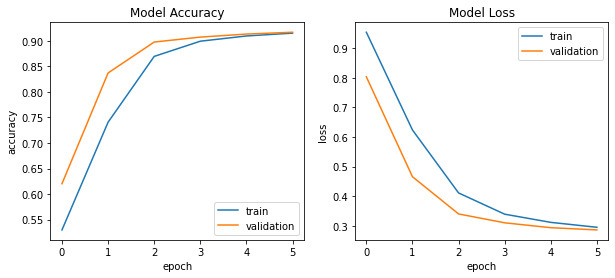

In [ ]:
def plot_training_hist(history):
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  
  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('accuracy')
  ax[0].legend(['train', 'validation'], loc='best')
  
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('loss')
  ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)